In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from joblib import Parallel, delayed

import sqlite3
import sys
import time
import math
#import tqdm
from tqdm.auto import tqdm
import datetime
import os
import pickle
from pathlib import Path

from glicko2 import Player
import multiprocessing

tqdm.pandas()

if os.path.exists('/workspace/data_2'):
    # Load the dictionary of DataFrames from the pickle
    data_path = '/workspace/data_2/'
else:
    data_path = '../data/'

## Load the data

Here, we assume that the ``sets_df`` file, potentially with player swapping, was saved as a separate pickle file.

In [6]:
dataset_df = pd.read_pickle(data_path + 'dataset_full.pkl')
dataset_df.sort_values(by=['end', 'start']) # Just to be sure

# If you want to use just the total instead.
dataset_df['matchup_total'] = dataset_df[['matchup_1', 'matchup_2',
       'matchup_3', 'matchup_4', 'matchup_5', 'matchup_6', 'matchup_7',
       'matchup_8', 'matchup_9', 'matchup_10']].sum(axis=1)

# If you wanna regress on the score ratio, rather than just the binary outcome
dataset_df['score_ratio'] = dataset_df[['p1_score', 'p2_score', 'valid_score']].apply(lambda row: row['p1_score'] / (row['p1_score'] + row['p2_score']) if row['valid_score'] else 0.5, axis=1)

dataset_df.columns

Index(['key_x', 'game', 'tournament_key', 'winner_id', 'loser_id', 'p1_id',
       'p2_id', 'p1_score', 'p2_score', 'valid_score',
       ...
       'p2/m1/m1_alt2_rd', 'p2/m1/m1_alt2_updates', 'p1/m1_alt3_elo',
       'p1/m1_alt3_rd', 'p1/m1_alt3_updates', 'p2/m1_alt3_elo',
       'p2/m1_alt3_rd', 'p2/m1_alt3_updates', 'matchup_total', 'score_ratio'],
      dtype='object', length=125)

In [7]:
features_default_elo = ['p1_default_elo', 'p2_default_elo']
features_all_elo = ['p1_default_elo', 'p2_default_elo', 'p1/m1/m1_alt2_elo', 'p2/m1/m1_alt2_elo', 'p1/m1_alt3_elo', 'p2/m1_alt3_elo']
features_all_rd = [x.replace('elo', 'rd') for x in features_all_elo]
features_all_updates = [x.replace('elo', 'updates') for x in features_all_elo]
features_all_eru = features_all_elo + features_all_rd + features_all_updates

# I'm lazy
features_all_everything = ['p1_default_elo', 'p2_default_elo', 'p1_default_rd', 'p2_default_rd',
       'p1_default_updates', 'p2_default_updates', 'matchup_1', 'matchup_2',
       'matchup_3', 'matchup_4', 'matchup_5', 'matchup_6', 'matchup_7',
       'matchup_8', 'matchup_9', 'matchup_10', 'p1_m1_usage', 'p2_m1_usage',
       'p1/m1/m1_alt2_elo', 'p1/m1/m1_alt2_rd', 'p1/m1/m1_alt2_updates',
       'p2/m1/m1_alt2_elo', 'p2/m1/m1_alt2_rd', 'p2/m1/m1_alt2_updates',
       'p1/m1_alt3_elo', 'p1/m1_alt3_rd', 'p1/m1_alt3_updates',
       'p2/m1_alt3_elo', 'p2/m1_alt3_rd', 'p2/m1_alt3_updates']

# Filter by elos that actually have very nontrivial data
quality_filter = pd.Series(True, index=dataset_df.index)
for update_col in features_all_updates:
    quality_filter = quality_filter & (dataset_df[update_col] >= 10.0)

low_quality_filter = pd.Series(True, index=dataset_df.index)
for update_col in features_all_updates:
    low_quality_filter = low_quality_filter & ((dataset_df[update_col] >= 2.0) & (dataset_df[update_col] <= 10.0))

similar_default_elo_filter = (dataset_df['p1_default_elo'] - dataset_df['p2_default_elo']).abs() <= 20.0

dataset_df[similar_default_elo_filter]

,key_x,game,tournament_key,winner_id,loser_id,p1_id,p2_id,p1_score,p2_score,valid_score,...,p2/m1/m1_alt2_rd,p2/m1/m1_alt2_updates,p1/m1_alt3_elo,p1/m1_alt3_rd,p1/m1_alt3_updates,p2/m1_alt3_elo,p2/m1_alt3_rd,p2/m1_alt3_updates,matchup_total,score_ratio
719,,melee,httpsbeastsmashchallongecomb5msb,Däumling,Schlimmshady,Schlimmshady,Däumling,0,2,True,...,350.000000,0.0,1500.000000,350.000000,0.0,1500.000000,350.000000,0.0,5.0,0.000000
773,,melee,httpsbeastsmashchallongecomb5msb,NamiNami,ProSmasherTim,ProSmasherTim,NamiNami,1,2,True,...,350.000000,0.0,1500.000000,350.000000,0.0,1500.000000,350.000000,0.0,5.0,0.333333
772,,melee,httpsbeastsmashchallongecomb5msb,Gusti,Kuja,Gusti,Kuja,2,1,True,...,350.000000,0.0,1500.000000,350.000000,0.0,1500.000000,350.000000,0.0,5.0,0.666667
771,,melee,httpsbeastsmashchallongecomb5msb,Mikehaggar,Fauster,Fauster,Mikehaggar,1,2,True,...,350.000000,0.0,1500.000000,350.000000,0.0,1500.000000,350.000000,0.0,5.0,0.333333
770,,melee,httpsbeastsmashchallongecomb5msb,V-Dogg,Dev,V-Dogg,Dev,2,1,True,...,350.000000,0.0,1500.000000,350.000000,0.0,1500.000000,350.000000,0.0,5.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792527,gg__76189357,melee,newsflash-59__super-smash-bros-melee-singles,148391,3822249,3822249,148391,0,3,False,...,341.183956,2.0,1572.660481,48.218999,5.0,1602.563043,67.308275,6.0,4.5,0.500000
1771307,gg__75580131,melee,triple-threat-tuesdays-30-the-peak__melee-singles,342875,1377337,1377337,342875,0,2,True,...,91.588819,13.0,1370.998161,51.384483,58.0,1338.705624,67.010325,20.0,3.0,0.000000
1489897,gg__67589317,melee,shuuten-tokyo-1__shuuten-1-melee-singles-shinjuku,34804,1158912,1158912,34804,1,2,True,...,113.408033,5.0,1285.261707,131.246926,2.0,1366.212582,99.257620,4.0,5.0,0.333333
1489903,gg__67589323,melee,shuuten-tokyo-1__shuuten-1-melee-singles-shinjuku,1602510,10565,1602510,10565,3,1,False,...,278.200801,2.0,1589.041503,106.374142,4.0,1579.035666,93.860494,6.0,5.0,0.500000


## NOTE: Skippable code below

Most of the code below involves forming various observations about the data and testing various models to see if they would improve prediction accuracy. Ultimately, most ideas fail, but they might still be interesting and are kept nonetheless, especially to see how well they perform relative to our best model.

Training and testing of our final model will resume near the end of this notebook, and a note is placed to show where this is.

## An observation about the data

First, we note the motivation for including ``quality_filter`` as an option for the data. With it, ELO scores appear to (mostly) follow a multivariate normal distribution, while lower-quality data tends to cluster far more around the default elo values of 1500. This suggests, at least in the case of high-quality data, that very simplistic linear models might actually yield the best performance.

In [ ]:
plt.title('default, alt2, alt3 ELOs for quality data')
plt.xticks([])
plt.yticks([])

for i in range(0,3):
    plt.subplot(3,2,2*i+1)
    plt.scatter(dataset_df[quality_filter & (dataset_df['winner'] == 1.0)][features_all_elo[2*i]],
                dataset_df[quality_filter & (dataset_df['winner'] == 1.0)][features_all_elo[2*i+1]],
                s=0.3, alpha=0.2, label='p1 wins')
    plt.xlim(0, 3000)
    plt.ylim(0, 3000)
    
    if i != 2:
        plt.xticks([])

    plt.legend()

    plt.subplot(3,2,2*i+2)
    plt.scatter(dataset_df[quality_filter & (dataset_df['winner'] == 0.0)][features_all_elo[2*i]],
                dataset_df[quality_filter & (dataset_df['winner'] == 0.0)][features_all_elo[2*i+1]],
                s=0.3, alpha=0.2, label='p2 wins')
    plt.xlim(0, 3000)
    plt.ylim(0, 3000)
    plt.legend()

    if i != 2:
        plt.xticks([])

    plt.yticks([])

plt.show()

## Testing some basic models

Before we begin, some important remarks are in order. In some sense, this is time series data, and in another sense, it is not. It somewhat showcases the evolution of player ELO ratings (and related features) over time, albeit without directly linking them to certain players. However, these ELO scores, in some sense, already take into account all of the player's past performance up to a certain point. Likewise, RD values are meant to indicate the "uncertainty" in any player's current ELO score, and at any one point in time it takes into account all of their previous games, and even how long it has been since they've last played.

That being said, it is somewhat ill-advised to shuffle the data when training. Especially for more advanced models, it might potentially be able to recognize that a very precise ELO score has shown up in some future match, and conclude that it must have won some previous matches (note that we have updated ELO scores only once a week).

Here, we begin by training some basic models that have the goal of predicting the outcome of individual sets, with no ability to look back on any past performance (single-set models). We first want to observe the impact of the following factors, and are not yet interested in serious hyperparameter tuning:

* Is it better to only train on more recent data rather than all data up to a certain point (perhaps game meta, average ELO, etc... shifts over time)
* Are we actually gaining anything by including all of our engineered ELO scores, rather than just the default ones?
* What is the impact of considering only on "high quality" data which has received many updates to all ELO scores?

We also note that for this single-set predictor, we train on data up to 2022 (and test on 2023) for cross-validation and hyperparameter tuning. The secondary model which takes tournament performance into account (which will use this single-set model), tuned on 2023 data and have its final performance tested on 2024 data. However, for the interest of obtaining a final performance score for the single-set predictor, it should be safely testable on 2024 data as well.

In [ ]:
# Models that only use the ELO scores
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import xgboost as xgb
from tqdm.auto import tqdm

from sklearn.metrics import log_loss, accuracy_score

# Years to train on. We will test on the next year.
years = range(2017, 2022+1)

# These models work best with normally distributed data, which appears to be the case for the various ELOs
models = {'lr': LogisticRegression(penalty=None, max_iter=10000),
          'lda': LinearDiscriminantAnalysis(),
          'qda': QuadraticDiscriminantAnalysis(),
          'xgb': xgb.XGBClassifier()}

ll_scores = np.zeros(shape=(len(years), len(models)))
acc_scores = np.zeros(shape=(len(years), len(models)))

training_modes = ['past_year', 'all_years'] # Train on just the past year, or all years (starting from 2016).
elo_modes = ['default_elo', 'all_elo'] # Only the default glicko2 elo scores, or all engineered ones
data_modes = ['quality_data', 'all_data'] # Whether or not each elo has had at least 10 updates

for training_mode in training_modes:
    for elo_mode in elo_modes:
        for data_mode in data_modes:
            # Just using default ELOs
            for i, y in enumerate(tqdm(years)):
                # Note that 2015 data is probably not that good. Elo scores barely started getting accurate.
                # NOTE: It is assumed that dataset_df and sets_df share the same rows, only with different engineered features in dataset_df
                dataset_train_df = dataset_df[(dataset_df['start'] >= datetime.datetime(2016 if training_mode == 'all_years' else y, 1, 1)) &
                                            (dataset_df['end'] <= datetime.datetime(y,12,31)) &
                                            (quality_filter if data_mode == 'quality_data' else True)]
                dataset_test_df = dataset_df[(dataset_df['start'] >= datetime.datetime(y+1,1,1)) &
                                            (dataset_df['end'] <= datetime.datetime(y+1,12,31)) &
                                            (quality_filter if data_mode == 'quality_data' else True)]
                
                for j, name in enumerate(models):
                    models[name].fit(dataset_train_df[features_default_elo if elo_mode == 'default_elo' else features_all_elo], dataset_train_df['winner'])
                    y_prob = models[name].predict_proba(dataset_test_df[features_default_elo if elo_mode == 'default_elo' else features_all_elo])
                    y_pred = (y_prob[:,1] >= 0.5)

                    ll_scores[i,j] = round(log_loss(dataset_test_df['winner'], y_prob), 3)
                    acc_scores[i,j] = round(100.0 * accuracy_score(dataset_test_df['winner'], y_pred), 1)

            print("Using " + training_mode + " and " + elo_mode + " and " + data_mode)
            print(pd.DataFrame(np.concatenate([ll_scores, acc_scores], axis=1),
                        index=years,
                        columns=[x + "_ll" for x in models] + [x + "_acc" for x in models]))

Of particular interest are the latter few years, because the data is of substantially higher quality, and it will also more closely follow years 2023 and 2024.

Without any need to run any statistical tests, a simple side-by-side comparison reveals that
* In all instances, training on all data seems to either do comparably, or substantially better (possibly due to poor quality data for that specific training year), than training on all data.
* LDA appears favourable over QDA.
* When dealing with higher-quality data, basic linear models substantially outperform XGBoost, at least without any hyperparameter tuning and training only on a very specific subset of the data. This could, however, be due to the substantially smaller dataset size in those instances.

## A closer look at linear models

Here, we test the following linear models in the case of high-quality data, and explicitly low-quality data. The models we will be testing are LogisticRegression (classification), LDA, and a custom ErrorLDA model which should take into account the various RD values (roughly interpreted as a measurement error on the player ELOs, with the "true" ELOs being unknown values).

In [ ]:
# More advanced models
import xgboost as xgb
import errorlda
import importlib

# Just in case we make changes to this model.
importlib.reload(errorlda)

# Years to train on. We will test on the next year.
years = range(2020, 2022+1)

models = {'lr': LogisticRegression(penalty=None, max_iter=10000),
          'lda': LinearDiscriminantAnalysis(),
          'errorlda': errorlda.ErrorLDA(),
          #'errorlda_scaling': errorlda.ErrorLDA(),
          'xgb': xgb.XGBClassifier()}

ll_scores = np.zeros(shape=(len(years), len(models)))
acc_scores = np.zeros(shape=(len(years), len(models)))

data_modes = ['low_quality', 'high_quality']

for data_mode in data_modes:
    for i, y in enumerate(tqdm(years)):
        # Note that 2015 data is probably not that good. Elo scores barely started getting accurate.
        # NOTE: It is assumed that dataset_df and sets_df share the same rows, only with different engineered features in dataset_df
        dataset_train_df = dataset_df[(dataset_df['start'] >= datetime.datetime(2016,1,1)) &
                                    (dataset_df['end'] <= datetime.datetime(y,12,31)) &
                                    (low_quality_filter if data_mode == 'low_quality' else quality_filter)]
        dataset_test_df = dataset_df[(dataset_df['start'] >= datetime.datetime(y+1,1,1)) &
                                    (dataset_df['end'] <= datetime.datetime(y+1,12,31)) &
                                    (low_quality_filter if data_mode == 'low_quality' else quality_filter)]
        
        for j, name in enumerate(models):
            y_prob = None
            y_pred = None

            # Basically, all of these require slightly different syntax and restriction of features
            # * ErrorLDA to include the variances (RD values)
            # * LDA to just use the the ELO values without RD values (mainly to compare to ErrorLDA)
            match name:
                case 'lr' | 'lda':
                    models[name].fit(dataset_train_df[features_all_elo], dataset_train_df['winner'])
                    y_prob = models[name].predict_proba(dataset_test_df[features_all_elo])

                case 'errorlda' | 'errorlda_scaling':
                    models[name] = errorlda.ErrorLDA() # Not sure if I've implemented .fit() to reset everything upon every new fit.

                    # Experimental pre-scaling of the RD values
                    pre_scaler = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

                    models[name].fit(dataset_train_df[features_all_elo], dataset_train_df['winner'],
                                    X_train_errors=dataset_train_df[features_all_rd].apply(lambda row: np.diag(row.to_numpy() ** 2) @ pre_scaler, axis=1),
                                    error_scaling=(True if name == 'errorlda_scaling' else False)) # Note that error-scaling is slower by like a factor of 8, unfortunately
                    
                    # Literally just for numerical stability, in case some eigenvalues are near zero.
                    # This will add 1 to each eigenvalue.
                    models[name].variance += np.identity(len(features_all_rd))
                    
                    y_prob = models[name].predict_proba(dataset_test_df[features_all_elo],
                                                        X_error=dataset_test_df[features_all_rd].apply(lambda row: np.diag(row.to_numpy() ** 2) @ pre_scaler, axis=1))

                case 'xgb': # Special syntax required here.
                    models[name].fit(dataset_train_df[features_all_elo + features_all_rd], dataset_train_df['winner'])
                    y_prob = models[name].predict_proba(dataset_test_df[features_all_elo + features_all_rd])

            # Rest of the prediction code is the same among all models    
            y_pred = (y_prob[:,1] >= 0.5)

            ll_scores[i,j] = round(log_loss(dataset_test_df['winner'], y_prob), 3)
            acc_scores[i,j] = round(100.0 * accuracy_score(dataset_test_df['winner'], y_pred), 1)

    print("Scores involving all ELOs and RDs in " + data_mode + " mode")
    print(pd.DataFrame(np.concatenate([ll_scores, acc_scores], axis=1),
                index=years,
                columns=[x + "_ll" for x in models] + [x + "_acc" for x in models]))

## The best linear model

At least from the looks of things, it does not appear that there is any noticeable difference in accuracy and log loss with the ErrorLDA model, compared to the other two linear models. As such, considering the enormous lack of speed in training these models, we will just stick with LogisticRegression() in such special cases for now.

## Using separate depending on the quality of the data

Here, we try another experimental approach, where we split the data into different "quality classes" (depending on the RD values of each elo), and train linear models on each class (and test if it is better than XGBoost in each case). We then combine all of the better models into one ensemble, and see if the quality of the predictions improve at all.

In [ ]:
# Split the data according to the various amount of updates ("no data/low quality data/high quality data")

def get_quality_encoding(row):
    result = ''

    for update_col in features_all_updates:
        #if row[update_col] >= 20.0:  # High quality
        #    result += '3'
        if row[update_col] >= 10.0:  # High quality
            result += '2'
        elif row[update_col] >= 3.0: # Low quality
            result += '1'
        else:                        # None (or basically none)
            result += '0'
    
    return result

dataset_df = dataset_df.copy() # Fixes "copy of a slice" nonsense
dataset_df['quality_class'] = dataset_df.apply(get_quality_encoding, axis=1)

dataset_df

In [ ]:
from sklearn.model_selection import train_test_split

# Splits off the data into different classes and applies distinct models to each
class SplitRegression:
    # min_data is the minimum number of occurences of a class to split it off
    def __init__(self, min_data=1000,
                 default_model=xgb.XGBClassifier()):
        self.features = None # Basically the list of columns of the training data
        self.min_data = min_data

        self.large_classes = None
        self.small_classes = None
        self.zero_classes = None

        self.large_models = {} # A dictionary of models, one for each class with lots of data
        self.large_models_reduced_features = {} # Keep track of whether to only pass reduced features to each large model

        # TODO: Possibly get rid of small/zero separation        
        self.small_model = default_model # Just bundle together all small classes (except zero) into one group and apply a more complex model to them
        self.zero_model = default_model # Apply another (possibly) separate model to the "basically no data" group

        self.default_model = default_model

    # Figure out what features we actually need to pull from (and ignore the ones that have basically zero data)
    def class_to_features(self, c):
        return [self.features[i] for i,x in enumerate(c) if x != '0']
    
    # Jankiness, but it works. If there is *technically* only one class in whatever we've split off here,
    # then we should make sure to add the other class. Ideally with fake data.
    def patch_missing_outcome(self, X_train, y_train):
        old_len = len(X_train.index)

        y_unique = list(y_train.unique()) # Could very well be empty, or just one value. This handles both cases.
        for y in [y for y in [0.0, 1.0] if y not in y_unique]:
            X_train = pd.concat([X_train, pd.DataFrame([1500.0] * len(X_train.columns), index=X_train.columns).T], axis=0) # Most canonical fake data
            y_train = pd.concat([y_train, pd.Series([y])])

        return X_train, y_train

    # Kind of assumes these are all dataframes and series-es
    # X_class corresponds to a unique id of the form n_1 ... n_k for the class
    # A value of n_i = 0 means we will not actually use data from that class
    def fit(self, X, y, X_class):
        # First and foremost, don't forget to fit the default model to all the data
        # (Subsequent models will be compared to it, and it will be used when they don't have better performance)
        self.default_model.fit(X,y)

        self.features = list(X.columns)

        class_counts = X_class.value_counts()

        # The zero classes, treated as separate classes. Realistically, there should only be at most one.
        self.zero_classes = [c for c in class_counts.index if self.class_to_features(c) == []]
        
        self.large_classes = [x for x in class_counts[class_counts >= self.min_data].index if x not in self.zero_classes]
        self.small_classes = [x for x in class_counts[class_counts < self.min_data].index if x not in self.zero_classes]

        # As we've seen, LogisticRegression does quite well on classes with lots of data.
        # We kind of assume each class has slightly different means, hence the need to train separate models,
        # and also just skip out entirely on passing it info from features with basically no info.
        #
        # Train and test such a model, and very importantly, actually see if it does better than the default!
        for c in self.large_classes:
            class_features = self.class_to_features(c)

            # Just in case the outcome is constant on this training subset.
            X_train, y_train = self.patch_missing_outcome(X[X_class == c], y[X_class == c])

            # Gonna assume some (possibly very slight) correlation between past and future entries, and so we avoid shuffling
            X_train_tt, X_train_ho, y_train_tt, y_train_ho = train_test_split(X_train, y_train, shuffle=False)

            default_ll = log_loss(y_train_ho, self.default_model.predict_proba(X_train_ho))

            test_model = LogisticRegression(penalty=None, max_iter=10000)

            test_model.fit(X_train_tt[class_features], y_train_tt)
            test_ll = log_loss(y_train_ho, test_model.predict_proba(X_train_ho[class_features]))

            # Depending on if we stick with the default or the new model,
            # we will also need to keep track of whether or not the features need to be reduced or not.
            if test_ll <= 0.9 * default_ll: # Just to account for RNG in some way
                test_model.fit(X_train[class_features], y_train) # Extra training data - let's not throw out the holdout set!
                self.large_models[c] = test_model
                self.large_models_reduced_features[c] = True
            else:
                self.large_models[c] = self.default_model
                self.large_models_reduced_features[c] = False

        # Now the zero classes (realistically at most one of them) get lumped together and have a single model used.
        # Same for the small classes.
        # Might as well toss all features in there, just in case it feels like extracting *some* kind of info, somehow.
        small_class_filter = X_class.apply(lambda c: c in self.small_classes)
        zero_class_filter = X_class.apply(lambda c: c in self.zero_classes)
        
        # TODO: Tuning of hyperparameters
        self.small_model = xgb.XGBClassifier()
        self.zero_model = xgb.XGBClassifier()        

        # These could technically be empty, or have just one outcome
        # Small class
        X_train, y_train = self.patch_missing_outcome(X[small_class_filter], y[small_class_filter])
        self.small_model.fit(X_train, y_train)
        # Zero class
        X_train, y_train = self.patch_missing_outcome(X[zero_class_filter], y[zero_class_filter])
        self.zero_model.fit(X_train, y_train)

    def predict_proba(self, X, X_class):

        merged_df = pd.concat([X, X_class], axis=1)
        merged_df.columns = list(X.columns) + ['quality_class']

        # It is substantially more efficient to figure out which model applies to which row,
        # use a groupby(), and feed the entire block of data into the model,
        # rather than doing this entire operation row by row.

        # Also, this breaks if we try to put the models directly in the dataframe.
        # Let's instead just assign them numeric values.
        model_list = [self.large_models[c] for c in self.large_models] + [self.zero_model, self.small_model]
        model_to_num_dict = {}

        for i, model in enumerate(model_list):
            model_to_num_dict[model] = i

        def assign_model(row):
            c = row['quality_class']

            if c in self.large_classes:
                return model_to_num_dict[self.large_models[c]]
            
            # Not a large model. Perhaps zero?
            if self.class_to_features(c) == []:
                return model_to_num_dict[self.zero_model]
            
            # Only possibility is the "small" model. Just lump it in with the rest of the data.
            return model_to_num_dict[self.small_model]
        
        merged_df['model'] = merged_df.apply(assign_model, axis=1)
        merged_df['model_copy'] = merged_df['model'] # include_groups=True deprecation nonsense

        # Run predict_proba on entire blocks of data that use the same model,
        # rather than running it row by row (slow)!
        def block_proba(df):
            model_num = df.iloc[0]['model_copy']
            c = df.iloc[0]['quality_class']
            c_features = df.columns[:-2] # Ignore 'quality_class' and 'model_copy' columns

            # Large model, might need to restrict features
            # (usually this is the case if it's not pointing to the default model)
            if model_num < len(self.large_models) and self.large_models_reduced_features[c]:
                c_features = self.class_to_features(c)
            
            model = model_list[model_num]
            
            return pd.DataFrame(model.predict_proba(df[c_features]), index=df.index)
        
        
        result = merged_df.groupby('model').apply(block_proba, include_groups=False)

        # Note that this will have a two-layered index now.
        # One for the model number, and one for the original index.
        # Let's remove it.
        result = result.droplevel(0)

        # NOTE: The index is NOT the original order anymore, because of the above! Let's fix that
        result = result.loc[X.index]

        return result.to_numpy()

In [ ]:
# More advanced models
import xgboost as xgb
import errorlda
import importlib

# Just in case we make changes to this model.
importlib.reload(errorlda)

# Years to train on. We will test on the next year.
years = range(2018, 2022+1)

models = {'split': SplitRegression(min_data=5000),
          'xgb': xgb.XGBClassifier()}

ll_scores = np.zeros(shape=(len(years), len(models)))
acc_scores = np.zeros(shape=(len(years), len(models)))



for i, y in enumerate(tqdm(years)):
    # Note that 2015 data is probably not that good. Elo scores barely started getting accurate.
    # NOTE: It is assumed that dataset_df and sets_df share the same rows, only with different engineered features in dataset_df
    dataset_train_df = dataset_df[(dataset_df['start'] >= datetime.datetime(2016,1,1)) &
                                (dataset_df['end'] <= datetime.datetime(y,12,31))]
    dataset_test_df = dataset_df[(dataset_df['start'] >= datetime.datetime(y+1,1,1)) &
                                (dataset_df['end'] <= datetime.datetime(y+1,12,31))]
    
    for j, name in enumerate(models):
        y_prob = None
        y_pred = None

        # Basically, all of these require slightly different syntax and restriction of features
        # * ErrorLDA to include the variances (RD values)
        # * LDA to just use the the ELO values without RD values (mainly to compare to ErrorLDA)
        match name:
            case 'split': # Special syntax required here.
                models[name].fit(dataset_train_df[features_all_elo], dataset_train_df['winner'], dataset_train_df['quality_class'])
                y_prob = models[name].predict_proba(dataset_test_df[features_all_elo], dataset_test_df['quality_class'])
            case 'xgb':
                models[name].fit(dataset_train_df[features_all_elo + features_all_rd], dataset_train_df['winner'])
                y_prob = models[name].predict_proba(dataset_test_df[features_all_elo + features_all_rd])

        # Rest of the prediction code is the same among all models    
        y_pred = (y_prob[:,1] >= 0.5)

        ll_scores[i,j] = round(log_loss(dataset_test_df['winner'], y_prob), 3)
        acc_scores[i,j] = round(100.0 * accuracy_score(dataset_test_df['winner'], y_pred), 1)

print("Scores involving all ELOs and RDs in " + data_mode + " mode")
print(pd.DataFrame(np.concatenate([ll_scores, acc_scores], axis=1),
            index=years,
            columns=[x + "_ll" for x in models] + [x + "_acc" for x in models]))

## On the above linear/XGBoost ensemble

Unfortunately, it again appears as if the performance of this ensemble is comparable (possibly ever so slightly worse) than untuned XGBoost. You'll have to take my word for it that this was tested on many different combinations of parameters and data test sets, and the results are remarkably consistent.

## Hyperparameter tuning

In [ ]:
import optuna

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import xgboost as xgb

years = range(2021, 2022+1)
restrict_to_top_8 = False

# Actually partition the data ahead of time, to avoid doing it every time.
# It will be the same, every single time.
data_partitioned = {}

for y in years: 
    dataset_train_df = dataset_df[(dataset_df['start'] >= datetime.datetime(2016,1,1)) &
                                  (dataset_df['end'] <= datetime.datetime(y,12,31)) &
                                  (dataset_df['top_8'] if restrict_to_top_8 else True)]
    dataset_test_df = dataset_df[(dataset_df['start'] >= datetime.datetime(y+1,1,1)) &
                                 (dataset_df['end'] <= datetime.datetime(y+1,12,31)) &
                                 (dataset_df['top_8'] if restrict_to_top_8 else True)]
    
    data_partitioned[y] = (dataset_train_df, dataset_test_df)

# Baseline results to compare to.
xgb_baseline = xgb.XGBClassifier()
results_baseline = np.zeros(len(years))

for i,y in enumerate(years):
    dataset_train_df = data_partitioned[y][0]
    dataset_test_df = data_partitioned[y][1]

    xgb_baseline.fit(dataset_train_df[features_all_everything], dataset_train_df['winner'])    
    y_prob = xgb_baseline.predict_proba(dataset_test_df[features_all_everything])

    results_baseline[i] = log_loss(dataset_test_df['winner'], y_prob)


def objective(trial):
    # Years to train on. We will train on one and test on the following.
    # Three years for vaguely decent cross-validation.
    results = np.zeros(len(years))

    for i,y in enumerate(years):

        # Far more efficient to compute these only once, as they don't actually change.
        dataset_train_df = data_partitioned[y][0]
        dataset_test_df = data_partitioned[y][1]

        max_depth        = trial.suggest_int("max_depth", 2, 10, step=1)
        learning_rate    = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
        n_estimators     = trial.suggest_int("n_estimators", 50, 1000, step=50)
        subsample        = trial.suggest_float("subsample", 0.6, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
        gamma            = trial.suggest_float("gamma", 0.0, 5.0)
        min_child_weight = trial.suggest_int("min_child_weight", 1, 10)

        # Let's not regularize, due to the large ELO scores and small other values
        #reg_lambda       = trial.suggest_float("lambda", 1e-3, 10.0, log=True)
        #reg_alpha        = trial.suggest_float("alpha", 1e-3, 10.0, log=True)

        model = xgb.XGBClassifier(max_depth=max_depth,
                                  learning_rate=learning_rate,
                                  n_estimators=n_estimators,
                                  subsample=subsample,
                                  colsample_bytree=colsample_bytree,
                                  gamma=gamma,
                                  min_child_weight=min_child_weight)
        
        model.fit(dataset_train_df[features_all_everything], dataset_train_df['winner'])

        y_prob = model.predict_proba(dataset_test_df[features_all_everything])
        results[i] = log_loss(dataset_test_df['winner'], y_prob)

    # See how much we've improved over the baseline.
    # Measured as the average fractional decrease in log loss

    return (results_baseline / results).mean()

    


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=1800)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

## NOTE: Skippable code ends

Resume running from here to train and save the final model. A small note that the previous cell is for running hyperparameter tuning on the final model, but that optimal values are already given in the cell below.

In [9]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Train the final single-set model to use for top 8 prediction
# Actually, we can train two. One for generic sets (to see how well someone has performed up to that point)
# and one more optimized for top 8 sets only.
dataset_train_df = dataset_df[(dataset_df['start'] >= datetime.datetime(2016,1,1)) &
                              (dataset_df['end'] <= datetime.datetime(2022,12,31))]

dataset_test_df = dataset_df[(dataset_df['start'] >= datetime.datetime(2024,1,1)) &
                             (dataset_df['end'] <= datetime.datetime(2024,12,31))]

dataset_test_top8_df = dataset_df[(dataset_df['start'] >= datetime.datetime(2024,1,1)) &
                                  (dataset_df['end'] <= datetime.datetime(2024,12,31)) &
                                  (dataset_df['top_8'])]


print("Test set size (all data): ", dataset_test_df.shape[0])
print("Test set size (top 8): ",    dataset_test_top8_df.shape[0])

print()

# Purely looking at who has the higher ELO
print("'Who has the higher ELO' all-data test")
print("Accuracy: ", round(100.0 * accuracy_score(dataset_test_df['winner'],
                                                 (dataset_test_df['p1_default_elo'] >= dataset_test_df['p2_default_elo']).astype(float)), 2))

print("'Who has the higher ELO' top8 test")
print("Accuracy: ", round(100.0 * accuracy_score(dataset_test_top8_df['winner'],
                                                 (dataset_test_top8_df['p1_default_elo'] >= dataset_test_top8_df['p2_default_elo']).astype(float)), 2))

print()


baseline_model = xgb.XGBClassifier()
baseline_model.fit(dataset_train_df[features_default_elo], dataset_train_df['winner'])

y_prob = baseline_model.predict_proba(dataset_test_df[features_default_elo])
print("XGBoost (default elo only) all-data test")
print("Log loss: ", round(log_loss(dataset_test_df['winner'], y_prob), 3))
print("Accuracy: ", round(100.0 * accuracy_score(dataset_test_df['winner'], y_prob[:,1] >= 0.5), 2))

y_prob = baseline_model.predict_proba(dataset_test_top8_df[features_default_elo])
print("XGBoost (default elo only) top8 test")
print("Log loss: ", round(log_loss(dataset_test_top8_df['winner'], y_prob), 3))
print("Accuracy: ", round(100.0 * accuracy_score(dataset_test_top8_df['winner'], y_prob[:,1] >= 0.5), 2))

print()

single_set_model = xgb.XGBClassifier(max_depth=8,
                                     learning_rate=0.011288,
                                     n_estimators=850,
                                     subsample=0.60077,
                                     colsample_bytree=0.98525,
                                     gamma=5,
                                     min_child_weight=10)

single_set_model.fit(dataset_train_df[features_all_everything], dataset_train_df['winner'])

# Test on 2024 data to see what the final performance roughly looks like
y_prob = single_set_model.predict_proba(dataset_test_df[features_all_everything])
print("XGBoost (all features) all-data test")
print("Log loss: ", round(log_loss(dataset_test_df['winner'], y_prob), 3))
print("Accuracy: ", round(100.0 * accuracy_score(dataset_test_df['winner'], y_prob[:,1] >= 0.5), 2))

y_prob = single_set_model.predict_proba(dataset_test_top8_df[features_all_everything])
print("XGBoost (all features) top8 test")
print("Log loss: ", round(log_loss(dataset_test_top8_df['winner'], y_prob), 3))
print("Accuracy: ", round(100.0 * accuracy_score(dataset_test_top8_df['winner'], y_prob[:,1] >= 0.5), 2))

# See feature importance
importance_weight = single_set_model.get_booster().get_score(importance_type='weight')
importance_gain = single_set_model.get_booster().get_score(importance_type='gain')
importance_cover = single_set_model.get_booster().get_score(importance_type='cover')

importance_df = pd.DataFrame({
    'Feature': importance_weight.keys(),  # Map f0, f1, ... to feature names
    'Weight': [importance_weight.get(f, 0) for f in importance_weight.keys()],
    'Gain': [importance_gain.get(f, 0) for f in importance_weight.keys()],
    'Cover': [importance_cover.get(f, 0) for f in importance_weight.keys()]
}).sort_values(by='Weight', ascending=False)

print(importance_df)
print()


Test set size (all data):  247608
Test set size (top 8):  58243

'Who has the higher ELO' all-data test
Accuracy:  77.54
'Who has the higher ELO' top8 test
Accuracy:  73.88

XGBoost (default elo only) all-data test
Log loss:  0.456
Accuracy:  79.04
XGBoost (default elo only) top8 test
Log loss:  0.527
Accuracy:  74.11

XGBoost (all features) all-data test
Log loss:  0.439
Accuracy:  79.86
XGBoost (all features) top8 test
Log loss:  0.512
Accuracy:  74.97
                  Feature   Weight        Gain         Cover
0          p1_default_elo  12875.0  383.010071   9716.694336
1          p2_default_elo  12405.0  285.458893   9982.966797
27         p2/m1_alt3_elo   8370.0   42.037930   4743.486816
24         p1/m1_alt3_elo   8307.0   30.942427   4671.899414
2           p1_default_rd   7640.0   29.098961   4247.143555
3           p2_default_rd   6827.0   32.539692   3837.238281
4      p1_default_updates   5326.0   44.226654   7225.262695
5      p2_default_updates   5292.0   46.274437   7735

In [10]:
# Define subsets based on 'matchup_1' in the test data
test_consistent_df = dataset_test_df[dataset_test_df['matchup_1'] == 1]
test_inconsistent_df = dataset_test_df[dataset_test_df['matchup_1'] == 0]
test_none_df = dataset_test_df[dataset_test_df['matchup_1'] == 0.5]

# Initialize dictionaries to store accuracies
model_names = ['Higher ELO', 'Baseline XGBoost', 'Single Set XGBoost']
accuracies = {model: {} for model in model_names}

# Colors matching the pie chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# -----------------------------
# 'Who has the higher ELO' model accuracies
# -----------------------------
print("'Who has the higher ELO' model accuracies")

# Overall accuracy
who_higher_overall_accuracy = accuracy_score(
    dataset_test_df['winner'],
    (dataset_test_df['p1_default_elo'] >= dataset_test_df['p2_default_elo']).astype(float)
)

# Consistent subset
who_higher_consistent_predictions = (test_consistent_df['p1_default_elo'] >= test_consistent_df['p2_default_elo']).astype(float)
who_higher_consistent_accuracy = accuracy_score(test_consistent_df['winner'], who_higher_consistent_predictions)

# Inconsistent subset
who_higher_inconsistent_predictions = (test_inconsistent_df['p1_default_elo'] >= test_inconsistent_df['p2_default_elo']).astype(float)
who_higher_inconsistent_accuracy = accuracy_score(test_inconsistent_df['winner'], who_higher_inconsistent_predictions)

# None subset
who_higher_none_predictions = (test_none_df['p1_default_elo'] >= test_none_df['p2_default_elo']).astype(float)
who_higher_none_accuracy = accuracy_score(test_none_df['winner'], who_higher_none_predictions)

# Store accuracies
accuracies['Higher ELO']['Consistent'] = who_higher_consistent_accuracy * 100
accuracies['Higher ELO']['Inconsistent'] = who_higher_inconsistent_accuracy * 100
accuracies['Higher ELO']['None'] = who_higher_none_accuracy * 100
accuracies['Higher ELO']['Overall'] = who_higher_overall_accuracy * 100

# -----------------------------
# Baseline XGBoost model (default elo only)
# -----------------------------
print("\nBaseline XGBoost model (default elo only) accuracies")

# Overall predictions
y_prob_overall = baseline_model.predict_proba(dataset_test_df[features_default_elo])
baseline_overall_accuracy = accuracy_score(dataset_test_df['winner'], y_prob_overall[:,1] >= 0.5)

# Consistent subset
y_prob_consistent = baseline_model.predict_proba(test_consistent_df[features_default_elo])
baseline_consistent_accuracy = accuracy_score(test_consistent_df['winner'], y_prob_consistent[:,1] >= 0.5)

# Inconsistent subset
y_prob_inconsistent = baseline_model.predict_proba(test_inconsistent_df[features_default_elo])
baseline_inconsistent_accuracy = accuracy_score(test_inconsistent_df['winner'], y_prob_inconsistent[:,1] >= 0.5)

# None subset
y_prob_none = baseline_model.predict_proba(test_none_df[features_default_elo])
baseline_none_accuracy = accuracy_score(test_none_df['winner'], y_prob_none[:,1] >= 0.5)

# Store accuracies
accuracies['Baseline XGBoost']['Consistent'] = baseline_consistent_accuracy * 100
accuracies['Baseline XGBoost']['Inconsistent'] = baseline_inconsistent_accuracy * 100
accuracies['Baseline XGBoost']['None'] = baseline_none_accuracy * 100
accuracies['Baseline XGBoost']['Overall'] = baseline_overall_accuracy * 100

# -----------------------------
# Single Set XGBoost model (all features)
# -----------------------------
print("\nSingle Set XGBoost model (all features) accuracies")

# Overall predictions
y_prob_overall = single_set_model.predict_proba(dataset_test_df[features_all_everything])
single_set_overall_accuracy = accuracy_score(dataset_test_df['winner'], y_prob_overall[:,1] >= 0.5)

# Consistent subset
y_prob_consistent = single_set_model.predict_proba(test_consistent_df[features_all_everything])
single_set_consistent_accuracy = accuracy_score(test_consistent_df['winner'], y_prob_consistent[:,1] >= 0.5)

# Inconsistent subset
y_prob_inconsistent = single_set_model.predict_proba(test_inconsistent_df[features_all_everything])
single_set_inconsistent_accuracy = accuracy_score(test_inconsistent_df['winner'], y_prob_inconsistent[:,1] >= 0.5)

# None subset
y_prob_none = single_set_model.predict_proba(test_none_df[features_all_everything])
single_set_none_accuracy = accuracy_score(test_none_df['winner'], y_prob_none[:,1] >= 0.5)

# Store accuracies
accuracies['Single Set XGBoost']['Consistent'] = single_set_consistent_accuracy * 100
accuracies['Single Set XGBoost']['Inconsistent'] = single_set_inconsistent_accuracy * 100
accuracies['Single Set XGBoost']['None'] = single_set_none_accuracy * 100
accuracies['Single Set XGBoost']['Overall'] = single_set_overall_accuracy * 100

# Print the accuracies for each model
for model in model_names:
    print(f"\nAccuracies for {model}:")
    for category in ['Consistent', 'Inconsistent', 'None', 'Overall']:
        print(f"{category} Accuracy: {accuracies[model][category]:.2f}%")


'Who has the higher ELO' model accuracies

Baseline XGBoost model (default elo only) accuracies

Single Set XGBoost model (all features) accuracies

Accuracies for Higher ELO:
Consistent Accuracy: 79.70%
Inconsistent Accuracy: 79.76%
None Accuracy: 75.43%
Overall Accuracy: 77.54%

Accuracies for Baseline XGBoost:
Consistent Accuracy: 79.62%
Inconsistent Accuracy: 79.72%
None Accuracy: 78.43%
Overall Accuracy: 79.04%

Accuracies for Single Set XGBoost:
Consistent Accuracy: 80.40%
Inconsistent Accuracy: 80.57%
None Accuracy: 79.26%
Overall Accuracy: 79.86%


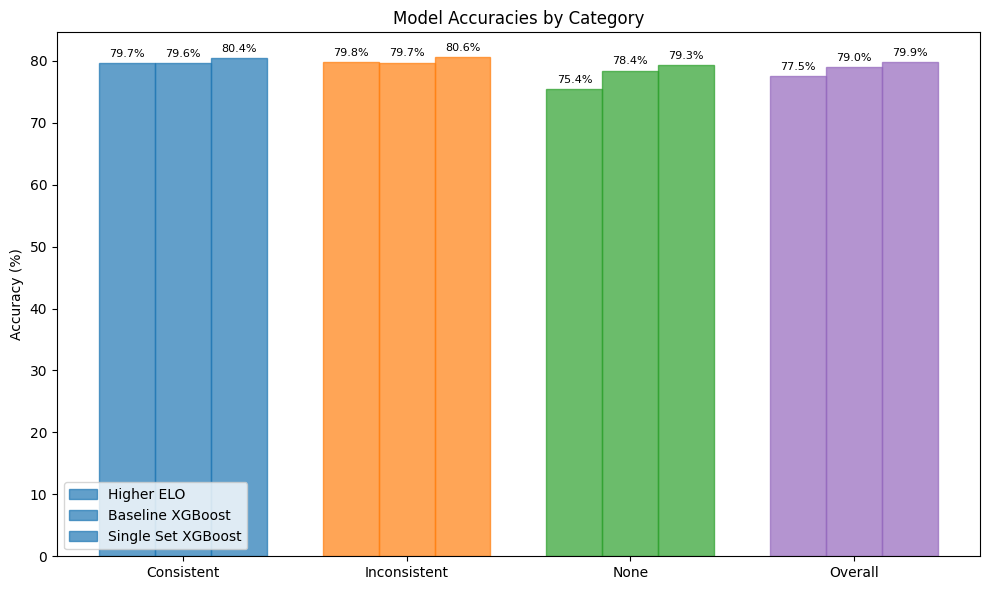

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Categories and colors
categories = ['Consistent', 'Inconsistent', 'None', 'Overall']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']  # Added a color for 'Overall'

# Prepare data for plotting
x = np.arange(len(categories))  # Label locations
width = 0.25  # Width of the bars

# Collect accuracies for each model
higher_elo_accuracies = [accuracies['Higher ELO'][cat] for cat in categories]
baseline_accuracies = [accuracies['Baseline XGBoost'][cat] for cat in categories]
single_set_accuracies = [accuracies['Single Set XGBoost'][cat] for cat in categories]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, higher_elo_accuracies, width, label='Higher ELO', alpha=0.7)
rects2 = ax.bar(x, baseline_accuracies, width, label='Baseline XGBoost', alpha=0.7)
rects3 = ax.bar(x + width, single_set_accuracies, width, label='Single Set XGBoost', alpha=0.7)

# Set colors for categories
for i, rect in enumerate(rects1):
    rect.set_color(colors[i])
for i, rect in enumerate(rects2):
    rect.set_color(colors[i])
for i, rect in enumerate(rects3):
    rect.set_color(colors[i])

# Add labels, title, and legend
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracies by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Function to add labels above bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset label above bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


In [8]:
# # Save the final model
# with open(data_path + 'single_set_model.pkl','wb') as f:
#     pickle.dump(single_set_model, f)

with open(data_path + 'single_set_model.pkl', 'rb') as f:
   single_set_model = pickle.load(f)